## this is the implementation of YOLO in Keras


#### Importing the relevant libraries

## PreProcessing of the images

In [1]:
%matplotlib inline
import numpy as np
from keras.models import Model
from keras.layers import (Input, Conv2D, MaxPooling2D,UpSampling2D, 
                          Conv2DTranspose, concatenate)
from keras.optimizers import Adam, SGD
import imageio
import tifffile as tiff
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import TensorBoard

Using TensorFlow backend.


## Combining Raster and Vector Data

+ Creating the building outline co-ordintates
+ The roads detection mapping of raster and vector data wont work here so you need to create a mapping
+ see what data labels are there in the raster and vector data set
+ Remember, more the number of layers, more will be the number of hyper parameters to tune and thus you will need more number of data points for training
+ The labels in the SpaceNet challenge are not bounding boxes, but rather polygons in a vector layer, or geojson. The flexibility of the polygonal label allows for more accurate localization than a bounding box but retains the ability to distinguish different objects of the same category (https://medium.com/the-downlinq/the-spacenet-metric-612183cc2ddb)
+ 

#### In order to achieve this the GeoJson file has the latitude and the longitude co-ordniates, and we need to convert it into pixels, so that we can then map it to the polygon structures which are present in the Summary file which comes with the data download


In [2]:
#importing the relevant libraries
from osgeo import gdal, osr
import numpy as np
import json
import rtree
import geojson
from geojson import Feature, Point, FeatureCollection, Polygon

In [18]:

####################
# download spacenet utilities from:
#  https://github.com/SpaceNetChallenge/utilities/tree/master/python/spaceNetUtilities
path_to_spacenet_utils = '/Users/mayank/utilities/python/spaceNetUtilities/'
sys.path.extend([path_to_spacenet_utils])
import geoTools as gT

In [9]:
f

<_io.TextIOWrapper name='/Users/mayank/Documents/College Documents/Capstone Project/Raw Data/SpaceNet_Roads_Sample/AOI_2_Vegas_Roads_Sample/geojson/spacenetroads/spacenetroads_AOI_2_Vegas_img230.geojson' mode='r' encoding='UTF-8'>

In [3]:
geo1='/Users/mayank/Documents/College Documents/Capstone Project/Raw Data/Buidings data set/AOI_2_LA/AOI_2_Vegas_Train/geojson/buildings/buildings_AOI_2_Vegas_img14.geojson'
with open(geo1) as f:
        geojson_data = json.load(f)
geojson_data['features']

[{'geometry': {'coordinates': [[[-115.30651591699996, 36.14957723300006, 0.0],
     [-115.30651539799999, 36.14954314400006, 0.0],
     [-115.306478, 36.14954351500006, 0.0],
     [-115.30647705599995, 36.149481380000054, 0.0],
     [-115.30651445399997, 36.149481009000056, 0.0],
     [-115.30651401499995, 36.149452100000076, 0.0],
     [-115.30660921299994, 36.149451157000044, 0.0],
     [-115.30661111399996, 36.14957629000003, 0.0],
     [-115.30651591699996, 36.14957723300006, 0.0]]],
   'type': 'Polygon'},
  'properties': {'AREA': 0.0,
   'FID_VEGAS_': 0,
   'FID_Vegas': 0,
   'Id': 0,
   'Name': 'None',
   'OBJECTID': 0,
   'OBJECTID_1': 0,
   'SISL': 0.0,
   'Shape_Area': 0.0,
   'Shape_Le_1': 0.0,
   'Shape_Le_2': 64.027718,
   'Shape_Le_3': 0.000515,
   'Shape_Leng': 0.0,
   'partialBuilding': 0.0,
   'partialDec': 1.0},
  'type': 'Feature'},
 {'geometry': {'coordinates': [[[-115.30628403599997, 36.149561290000065, 0.0],
     [-115.3063912599999, 36.149515259000054, 0.0],
     

In [11]:
print(geojson_data)

feature_collection = FeatureCollection(geojson_data)

print (feature_collection)

{'type': 'FeatureCollection', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}, 'features': [{'type': 'Feature', 'properties': {'OBJECTID': 0, 'FID_VEGAS_': 0, 'Id': 0, 'FID_Vegas': 0, 'Name': 'None', 'AREA': 0.0, 'Shape_Leng': 0.0, 'Shape_Le_1': 0.0, 'SISL': 0.0, 'OBJECTID_1': 0, 'Shape_Le_2': 64.027718, 'Shape_Le_3': 0.000515, 'Shape_Area': 0.0, 'partialBuilding': 0.0, 'partialDec': 1.0}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-115.30651591699996, 36.14957723300006, 0.0], [-115.30651539799999, 36.14954314400006, 0.0], [-115.306478, 36.14954351500006, 0.0], [-115.30647705599995, 36.149481380000054, 0.0], [-115.30651445399997, 36.149481009000056, 0.0], [-115.30651401499995, 36.149452100000076, 0.0], [-115.30660921299994, 36.149451157000044, 0.0], [-115.30661111399996, 36.14957629000003, 0.0], [-115.30651591699996, 36.14957723300006, 0.0]]]}}, {'type': 'Feature', 'properties': {'OBJECTID': 0, 'FID_VEGAS_': 0, 'Id': 0, 'FID_Vegas': 0, 'Name': 'N

In [7]:
geo3 = '/Users/mayank/Documents/College Documents/Capstone Project/Raw Data/SpaceNet_Roads_Sample/AOI_2_Vegas_Roads_Sample/geojson/spacenetroads/spacenetroads_AOI_2_Vegas_img230.geojson'
with open(geo3) as f:
        geojson_data = json.load(f)
geojson_data['features']

[{'geometry': {'coordinates': [[-115.2829476, 36.169356336758106],
    [-115.28292612437, 36.16936492701]],
   'type': 'LineString'},
  'properties': {'bridge_typ': '2',
   'heading': '0',
   'lane_numbe': '2',
   'lane_number': '2',
   'one_way_ty': '2',
   'origarea': 0,
   'origlen': 0.0022748156495480862,
   'partialDec': 1,
   'paved': '2',
   'road_id': 12886,
   'road_type': '6',
   'truncated': 0},
  'type': 'Feature'},
 {'geometry': {'coordinates': [[[-115.2794376, 36.16817809709251],
     [-115.28012998055, 36.16817187811],
     [-115.28021257015, 36.16817113629],
     [-115.28061081733, 36.16817113629],
     [-115.28143291331, 36.16815406855],
     [-115.28181978201, 36.16815122393],
     [-115.28236594958, 36.16812562232],
     [-115.2829476, 36.16810900373338]],
    [[-115.2794376, 36.1674855822],
     [-115.27968062569, 36.1674855822],
     [-115.28013860995, 36.1674855822],
     [-115.2810688016, 36.16746851446],
     [-115.28232896948, 36.16743437899],
     [-115.282947

In [8]:
print(geojson_data)

feature_collection = FeatureCollection(geojson_data)

print (feature_collection)

{'type': 'FeatureCollection', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}, 'features': [{'type': 'Feature', 'properties': {'bridge_typ': '2', 'heading': '0', 'lane_numbe': '2', 'lane_number': '2', 'one_way_ty': '2', 'paved': '2', 'road_id': 12886, 'road_type': '6', 'origarea': 0, 'origlen': 0.0022748156495480862, 'partialDec': 1, 'truncated': 0}, 'geometry': {'type': 'LineString', 'coordinates': [[-115.2829476, 36.169356336758106], [-115.28292612437, 36.16936492701]]}}, {'type': 'Feature', 'properties': {'bridge_typ': '2', 'heading': '0', 'lane_numbe': '1', 'lane_number': '1', 'one_way_ty': '2', 'paved': '1', 'road_id': 22658, 'road_type': '5', 'origarea': 0, 'origlen': 0.018204598699945854, 'partialDec': 1, 'truncated': 0}, 'geometry': {'type': 'MultiLineString', 'coordinates': [[[-115.2794376, 36.16817809709251], [-115.28012998055, 36.16817187811], [-115.28021257015, 36.16817113629], [-115.28061081733, 36.16817113629], [-115.28143291331, 36.168154

## Model creation module

The major outline is

+ Initialization
    + Data preparation will require you to trasnform the images into relevant formats, you might have to employ openCV for it
    + Run this script to convert annotations in COCO format to VOC format
        + https://gist.github.com/chicham/6ed3842d0d2014987186#file-coco2pascal-py
    + Specify the directory of train annotations (train_annot_folder) and train images (train_image_folder)
    + Specify the directory of validation annotations (valid_annot_folder) and validation images (valid_image_folder)
    
+ Construct equivalent network in Keras
    + Network arch from https://github.com/pjreddie/darknet/blob/master/cfg/yolo-voc.cfg

+ Perform training 
+ Perform detection on an image with newly trained weights


In [3]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import imgaug as ia
from tqdm import tqdm
from imgaug import augmenters as iaa
import numpy as np
import pickle
import os, cv2
#from preprocessing import BatchGenerator
#from preprocessing import parse_annotation
#from utils import WeightReader, decode_netout, draw_boxes

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

%matplotlib inline

(650, 650)


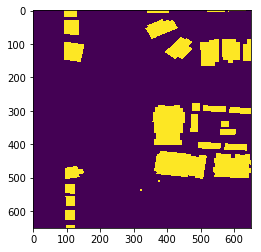

In [9]:
#checking the input image attributes
sam_path="/Users/mayank/Documents/College Documents/Capstone Project/Raw Data/Buidings data set/AOI_2_LA/AOI_2_Vegas_Train/Output1/building_mask/RGB-PanSharpen_AOI_2_Vegas_img12.tif"
img=tiff.imread(sam_path)
print(img.shape)
plt.imshow(img)
plt.show()

In [16]:
from PIL import Image

from resizeimage import resizeimage

img2=img.resize((200, 200,8), Image.ANTIALIAS)

TypeError: 'tuple' object cannot be interpreted as an integer

In [20]:
(img[:1])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

imgaug is giving certain issues, so refer this http://imgaug.readthedocs.io/en/latest/source/installation.html

In [4]:
#check what all labels are there in the masked data set
LABELS = ["Building"]

#check the input image width and height and put it here
IMAGE_H, IMAGE_W = 416, 416
#this is the default configuration for YOLO, decides on how the image needs to be broken down into different grid 
#sizes. Or 169 grids

GRID_H,  GRID_W  = 13 , 13

#this could be the number of anchor boxes we are placing, the default number here is 3, but depending upon the images
#you will be using as an input you can change this number
BOX              = 5

#number of classes which we are required to predict
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')

#this threshold pertaining to Pc, also the default configuration
OBJ_THRESHOLD    = 0.3#0.5

#Non Max Supression threshold i.e. the other boxes will be neglected for which the Pc is less than 0.3,
#also the default configuration
NMS_THRESHOLD    = 0.3#0.45

ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0
#how is batch size being implemented in the formula?
BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
#
TRUE_BOX_BUFFER  = 50

## Constructing the network

In [5]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

+ Stride is the number of skips you need to do while using convolutional layer
+ We arent using any bias in the architecture as of now
+ Batch Normalization?
+ Leaky RELU activation fucntion, f(x) = alpha * x for x < 0, f(x) = x for x >= 0
+ Max Pooling will take the max of the 2by2 matrix

In [6]:
from IPython.display import Image

## Output of YOLO

You've gathered all these images into a folder and have labelled them by drawing bounding boxes around every car you found. Here's an example of what your bounding boxes look like.

<img src="/Users/mayank/Documents/College Documents/Capstone Project/Research/Dump/Image1.png" style="width:500px;height:250;">
<caption><center> <u> **Figure 1** </u>: **Definition of a box**<br> </center></caption>

PATH = "/Users/mayank/Documents/College Documents/Capstone Project/Research/Dump/Image1.png"
Image(filename = PATH + "My_picture.jpg", width=100, height=100)

If you have 80 classes that you want YOLO to recognize, you can represent the class label $c$ either as an integer from 1 to 80, or as an 80-dimensional vector (with 80 numbers) one component of which is 1 and the rest of which are 0. The video lectures had used the latter representation; in this notebook, we will use both representations, depending on which is more convenient for a particular step.  

In this exercise, you will learn how YOLO works, then apply it to car detection. Because the YOLO model is very computationally expensive to train, we will load pre-trained weights for you to use. 

![title](img/Image1.png)

In [7]:
#here it is taking into account that the input image is RGB, adjust these parameters as per your image size
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))

##research on true box buffer??
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

# Layer 1
#using 32, 3 by 3 filters with a stride of 1, same padding means the input and output vector sizes are going to be same
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
#ideally here it should be that the BOX parameter is the numebr of Anchor boxes we have used, 4 relates to the 
#boundign box parameters, 1 is for the probability of a object in that grid, and CLASS is the number of classes we have
#or are trying to predict
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)

#the below mentioned matrix is the final output of YOLO, refer notes for more explanation on this
#possible hint could be : A product of reshape arguments should be equal to a length of an array which you are changing

output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([input_image, true_boxes], output)

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 416, 416, 32) 0           norm_1[0][0]                     
__________________________________________________________________________________________________
max_poolin

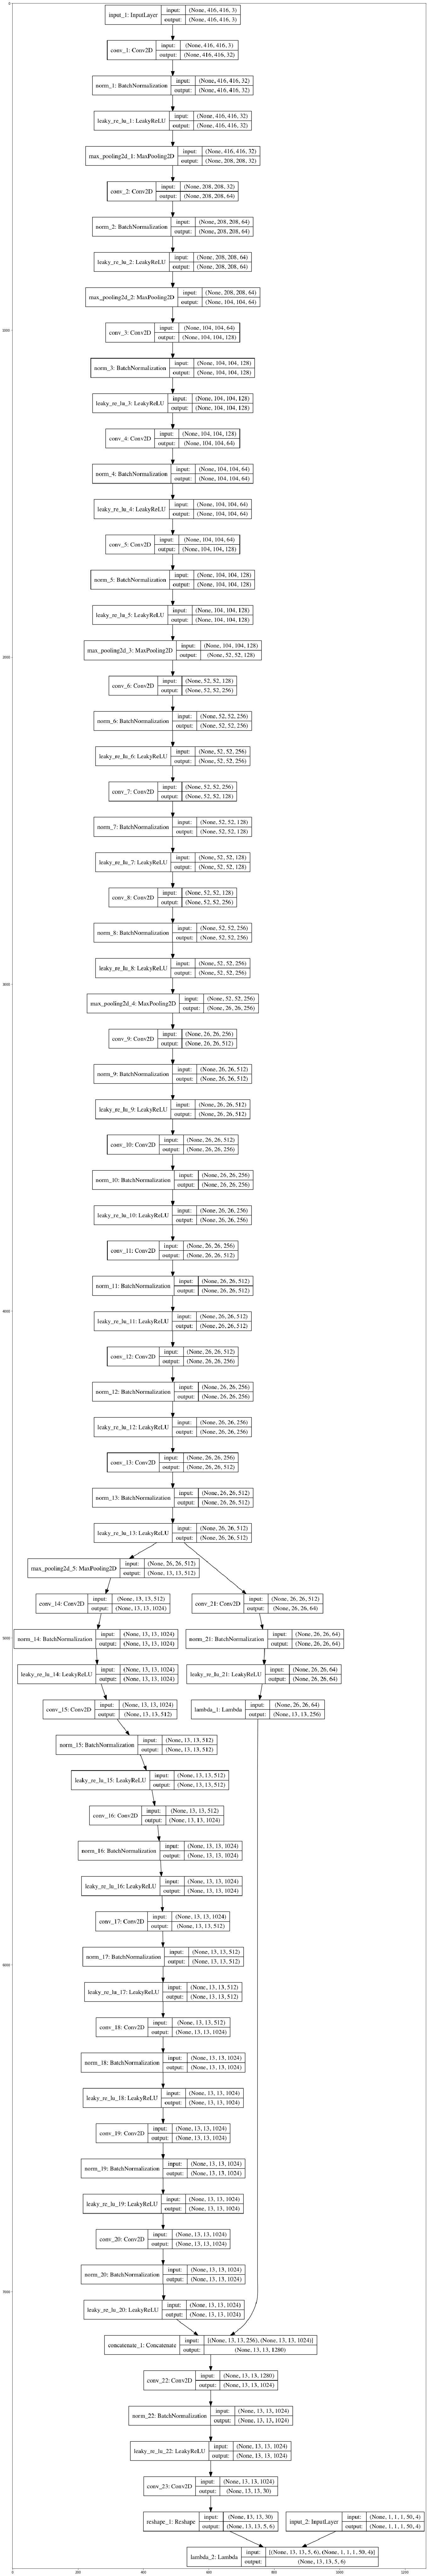

In [21]:
import imageio
import matplotlib as mpl
from matplotlib import pyplot as plt 
from keras.utils import plot_model
mpl.rcParams['figure.figsize'] = (150,150)  # plot sizes

plot_model(model, to_file='YOLO_Arch.png', show_shapes=True)
plt.imshow(imageio.imread('YOLO_Arch.png'))

## For training the model you can use the initial weights provided by YOLO

In [ ]:
#download the weights at this path location, you can experiment with v2 and v3
weight_reader = WeightReader(wt_path)

In [ ]:
weight_reader.reset()
nb_conv = 23

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    
    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

## ?? How and where would we iterate the learning rate, momentum and other parameters??

### Randomize the weights of the last layer

In [ ]:
layer   = model.layers[-4] # the last convolutional layer
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

## You can use initial weights from any distribution as well

## Perform training
Loss function
$$\begin{multline}
\lambda_\textbf{coord}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
     L_{ij}^{\text{obj}}
            \left[
            \left(
                x_i - \hat{x}_i
            \right)^2 +
            \left(
                y_i - \hat{y}_i
            \right)^2
            \right]
\\
+ \lambda_\textbf{coord} 
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
         L_{ij}^{\text{obj}}
         \left[
        \left(
            \sqrt{w_i} - \sqrt{\hat{w}_i}
        \right)^2 +
        \left(
            \sqrt{h_i} - \sqrt{\hat{h}_i}
        \right)^2
        \right]
\\
+ \sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
        L_{ij}^{\text{obj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \lambda_\textrm{noobj}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
    L_{ij}^{\text{noobj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \sum_{i = 0}^{S^2}
L_i^{\text{obj}}
    \sum_{c \in \textrm{classes}}
        \left(
            p_i(c) - \hat{p}_i(c)
        \right)^2
\end{multline}$$

+ here the lambdas are just used as a regularizer, generally lower penatly is on the term which is responsible for no object to ber there in a grid
+ if you see here, xi snd yi have a higher error contribution in the loss fuction as compared to the width and the height variables, this is done to establish the fact that locating the center of the bounding box is more important than the height and width
+ s^2 describes the grid size
+ Ci describes the whether there is an object within a grid or not
+ B represents the number of BBoxes you have in the algo
+ Pi's are the class probabilities of the different number of classes you have

In [26]:
#testing codes or rough codes, get rid of them later
t = tf.constant([[[1, 1, 1,1], [2, 2, 2,2]], [[3, 3, 3,3], [4, 4, 4,4]]])
test=tf.shape(t)[:4]
print(test.shape)
print(test)

(3,)
Tensor("strided_slice_3:0", shape=(3,), dtype=int32)


In [1]:
#below is the implementation of the above explained loss function
#this is the base optimzation algorithm of YOLO
def custom_loss(y_true, y_pred):

    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

## The use of the algorithm and codes hereforth are for the customized log loss function we have created above. This will be the exact replication of YOLO

#### Parse the annotations to construct train generator and validation generator

In [86]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

In [ ]:
#look up on why this sort of normalization is happenin here, do we need it or YOLO will take care of it by default?
def normalize(image):
    return image / 255.

In [ ]:
#the below code is for locating where the training images are and where their respective makssk are, so you can 
#probably just fix it initially


train_imgs, seen_train_labels = parse_annotation(train_annot_folder, train_image_folder, labels=LABELS)
### write parsed annotations to pickle for fast retrieval next time
#with open('train_imgs', 'wb') as fp:
#    pickle.dump(train_imgs, fp)

### read saved pickle of parsed annotations
#with open ('train_imgs', 'rb') as fp:
#    train_imgs = pickle.load(fp)
train_batch = BatchGenerator(train_imgs, generator_config, norm=normalize)

valid_imgs, seen_valid_labels = parse_annotation(valid_annot_folder, valid_image_folder, labels=LABELS)
### write parsed annotations to pickle for fast retrieval next time
#with open('valid_imgs', 'wb') as fp:
#    pickle.dump(valid_imgs, fp)

### read saved pickle of parsed annotations
#with open ('valid_imgs', 'rb') as fp:
#    valid_imgs = pickle.load(fp)
valid_batch = BatchGenerator(valid_imgs, generator_config, norm=normalize, jitter=False)

## Early stoppings and Checkpoints to stop the training after we have reached a particular threshold

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('weights_coco.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

## Training the model on the basis of the custom loss function

In [ ]:
tb_counter  = len([log for log in os.listdir(os.path.expanduser('~/logs/')) if 'coco_' in log]) + 1
tensorboard = TensorBoard(log_dir=os.path.expanduser('~/logs/') + 'coco_' + '_' + str(tb_counter), 
                          histogram_freq=0, 
                          write_graph=True, 
                          write_images=False)

optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer)

model.fit_generator(generator        = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 100, 
                    verbose          = 1,
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch),
                    callbacks        = [early_stop, checkpoint, tensorboard], 
                    max_queue_size   = 3)

In [ ]:
#you can use the code to run this model as well
# Now training the model:
N_EPOCHS = 200
BATCH_SIZE = 32

# Fit:
model.fit(x=x1, y=mask1, epochs=N_EPOCHS,verbose=0, shuffle=True)

In [ ]:
pred1 = model.predict(x1)
pred_img1 = pred1[0][:,:,0]
plt.imshow(pred_img1)

In [ ]:
pred_img1[pred_img1>0.5]=1
plt.imshow(pred_img1)

In [ ]:
# predict using second image
pred = model.predict(x2)
pred_img = pred[0][:,:,0]
plt.imshow(pred_img)

In [ ]:
pred_img[pred_img >0.1]=1
plt.imshow(pred_img)

In [ ]:
# plot ground truth for second image
tiff.imshow(mask2)

In [ ]:
tiff.imshow(tiff.imread(img2))